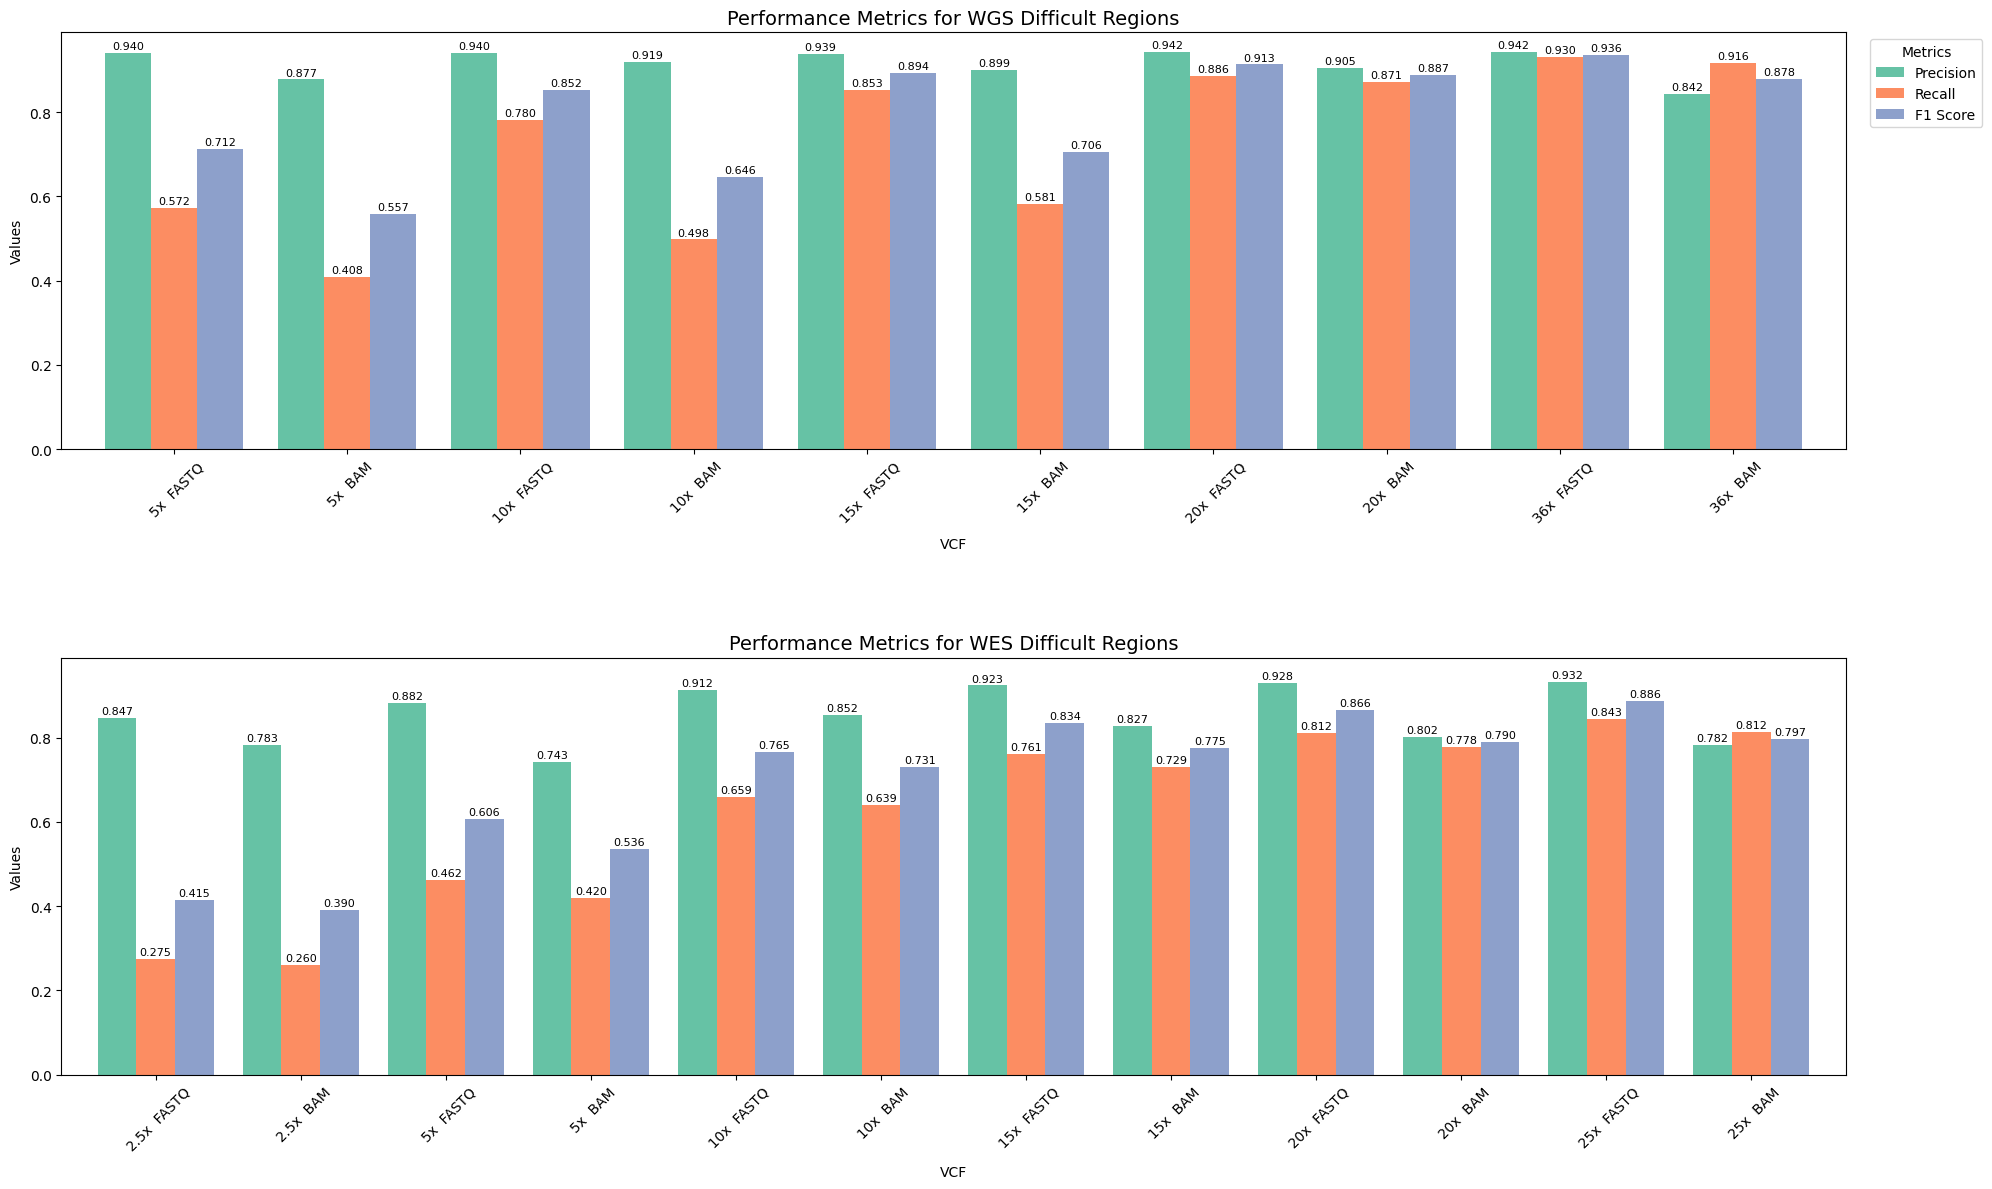

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cyvcf2 import VCF

# Store reference files and sample VCFs for normals and difficultregions
datasets = {
    'normals': {
        'reference': 'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficultregions.vcf',
        'vcf_files': [
            'wgs_5xdepth_FASTQ_difficultregions.vcf', 'wgs_5xdepth_BAM_difficultregions.vcf',
            'wgs_10xdepth_FASTQ_difficultregions.vcf', 'wgs_10xdepth_BAM_difficultregions.vcf',
            'wgs_15xdepth_FASTQ_difficultregions.vcf', 'wgs_15xdepth_BAM_difficultregions.vcf',
            'wgs_20xdepth_FASTQ_difficultregions.vcf', 'wgs_20xdepth_BAM_difficultregions.vcf',
            'wgs_36xdepth_FASTQ_difficultregions.vcf', 'wgs_36xdepth_BAM_difficultregions.vcf',
            'wgs_HG002_GRCh38_1_22_v4.2.1_benchmark_difficultregions.vcf'  # Will be removed from plot later
        ]
    },
    'difficultregions': {
        'reference': 'wes_HG002_GRCh38_1_22_difficultregions.vcf',
        'vcf_files': [
            'wes_2.5xdepth_FASTQ_difficultregions.vcf', 'wes_2.5xdepth_BAM_difficultregions.vcf',
            'wes_5xdepth_FASTQ_difficultregions.vcf', 'wes_5xdepth_BAM_difficultregions.vcf',
            'wes_10xdepth_FASTQ_difficultregions.vcf', 'wes_10xdepth_BAM_difficultregions.vcf',
            'wes_15xdepth_FASTQ_difficultregions.vcf', 'wes_15xdepth_BAM_difficultregions.vcf',
            'wes_20xdepth_FASTQ_difficultregions.vcf', 'wes_20xdepth_BAM_difficultregions.vcf',
            'wes_25xdepth_FASTQ_difficultregions.vcf', 'wes_25xdepth_BAM_difficultregions.vcf',
            'wes_HG002_GRCh38_1_22_difficultregions.vcf'  # Will be removed from plot later
        ]
    }
}

# Container for results
all_metrics = []

# Process both normals and difficultregions
for variant_type, data in datasets.items():
    vcf_reference = VCF(data['reference'])
    variants_ref = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf_reference)

    for vcf_file in data['vcf_files']:
        if vcf_file == data['reference']:  # Skip plotting reference
            continue

        vcf = VCF(vcf_file)
        variants_sample = set((v.CHROM, v.POS, v.REF, tuple(v.ALT)) for v in vcf)

        true_positive = len(variants_sample & variants_ref)
        false_positive = len(variants_sample - variants_ref)
        false_negative = len(variants_ref - variants_sample)

        precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
        recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
        f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        all_metrics.append({
            'VCF': vcf_file,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'Total Variants': true_positive + false_positive,
            'Type': variant_type
        })

# Convert to Pandas for plotting
df = pd.DataFrame(all_metrics)

# Simplify labels
def simplify_label(filename):
    return filename.replace('.vcf', '').replace('_difficultregions', '') \
                   .replace('depth', '').replace('x', 'x ').replace('_', ' ').replace('wgs', ' ').replace('wes', ' ') 
df['VCF'] = df['VCF'].apply(simplify_label)

# Split by type
df_normals = df[df['Type'] == 'normals'].copy()
df_difficultregions = df[df['Type'] == 'difficultregions'].copy()

# Reset index for plotting
df_normals.reset_index(drop=True, inplace=True)
df_difficultregions.reset_index(drop=True, inplace=True)

# Create vertically stacked plots
fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharey=True)

# Define colors matching Seaborn's Set2 for consistency
custom_colors = ['#66c2a5', '#fc8d62', '#8da0cb']

# normals plot
ax1 = df_normals[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[0], width=0.8, color=custom_colors
)
ax1.set_title('Performance Metrics for WGS Difficult Regions', fontsize=14)
ax1.set_ylabel('Values')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(title='Metrics', bbox_to_anchor=(1.01, 1), loc='upper left')

for p in ax1.patches:
    if p.get_height() > 0:
        ax1.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

# difficultregions plot
ax2 = df_difficultregions[['VCF', 'Precision', 'Recall', 'F1 Score']].plot(
    kind='bar', x='VCF', ax=axes[1], width=0.8, color=custom_colors, legend=False
)
ax2.set_title('Performance Metrics for WES Difficult Regions', fontsize=14)
ax2.set_ylabel('Values')
ax2.tick_params(axis='x', rotation=45)

for p in ax2.patches:
    if p.get_height() > 0:
        ax2.annotate(f'{p.get_height():.3f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center', xytext=(0, 5),
                     textcoords='offset points', fontsize=8)

plt.tight_layout()

plt.subplots_adjust(hspace=0.5)  # Increase the value for more spacing

# Save high-res version
plt.savefig("Difficult Regions.png", dpi=300)  # or use SVG if preferred
plt.show()
